In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

## Plotting harmonized NDVI time-series some regions

In [5]:
model_var='NDVI'
crs='epsg:4326'
name='trees'

# #Tassie
lat=slice(-40,-45) 
lon=slice(144,149)
name = 'Tasmania'

# #queensland
# lat=slice(-10,-20) 
# lon=slice(140,150)
# name='Northern Queensland'

# #SW WA
# lat=slice(-31,-36) 
# lon=slice(114.5,119)
# name='Southwest WA'




In [ ]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

merge = assign_crs(xr.open_dataset(base+'NDVI_harmonization/NDVI_LGBM_5km_monthly_1982_2022_wGaps.nc'),
                   crs='epsg:4326')['NDVI']

avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)

# merge = merge.isel(x=range(625,715), y=range(650,755))

In [6]:
mask = ~np.isnan(merge)

trees = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

if name=='trees':
    mask1 = xr.where(trees>0.25, 1, 0)
if name=='nontrees':
    mask1 = xr.where(trees<=0.25, 1, 0)

mask = round_coords(mask)
mask1 = round_coords(mask1)

In [11]:
merge = merge.sel(time=slice('1982','2000-02'))
avhrr = avhrr.sel(time=slice('1982','2000-02'))

In [35]:
avhrr = avhrr.where(mask)

merge = merge.where(mask1)
avhrr = avhrr.where(mask1)
modis = modis.where(mask1)

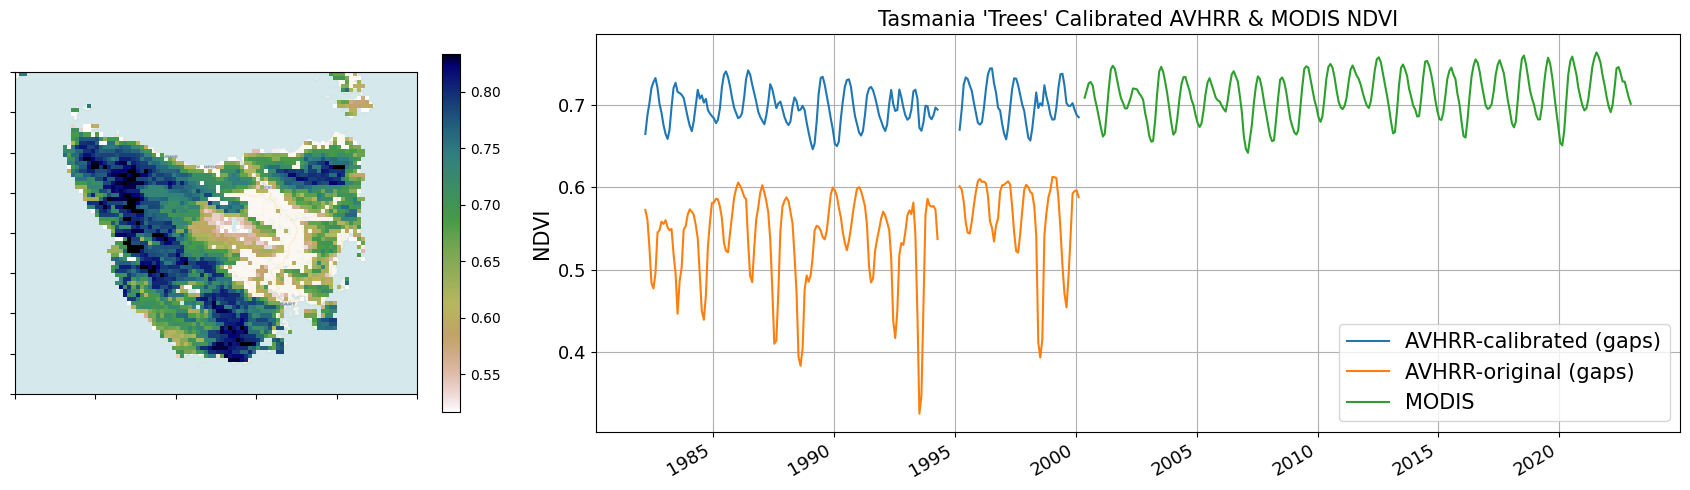

In [82]:
mosiac = [
    ["A", "B", "B"],
]

fig, ax = plt.subplot_mosaic(mosiac, figsize=(17,5))

im = modis.sel(longitude=lon, latitude=lat).mean('time').plot(robust=True, cmap='gist_earth_r',ax=ax['A'], add_colorbar=False, add_labels=False) 
cbar = plt.colorbar(im, ax=ax['A'], shrink=0.9)
ax['A'].set_yticklabels([])
ax['A'].set_ylabel('')
ax['A'].set_xlabel('')
ax['A'].set_xticklabels([])
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

ax["B"].grid(True)
merge.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax["B"], label='AVHRR-calibrated (gaps)')
avhrr.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax["B"], label='AVHRR-original (gaps)')
modis.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax["B"], label='MODIS')
ax["B"].legend(fontsize=15)
ax["B"].set_title(name+" 'Trees' Calibrated AVHRR & MODIS NDVI", fontsize=15)
ax["B"].set_ylabel('NDVI', fontsize=15)
ax["B"].set_xlabel(None)
ax['B'].tick_params(axis='y', labelsize=13)
ax['B'].tick_params(axis='x', labelsize=13)
plt.tight_layout();

fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Tassie_trees_timeseries.png", bbox_inches='tight', dpi=300);

### 

In [ ]:
# ndvi = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc')

In [ ]:
# ndvi.isel(longitude=slice(600,800), latitude=slice(0,230)).mean('time').plot()

In [ ]:
# merge_lgbm.sel(longitude=slice(140,150), latitude=slice(-10,-20)).mean(['x','y']).rolling(time=3).mean().plot(figsize=(11,4))
# plt.title("Tropical Forests QLD ('trees') Calibrated AVHRR & MODIS NDVI")

In [ ]:
ndvi.NDVI.where(mask).sel(longitude=slice(140,150), latitude=slice(-10,-20)).mean(['latitude','longitude']).rolling(time=3).mean().plot(figsize=(11,4))
plt.title("Tropical Forests QLD ('trees') Calibrated AVHRR & MODIS NDVI")

## Comparing the different models

In [ ]:
var='ndvi'
crs='epsg:3577'
name='nontrees'

merge = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+var.upper()+'_harmonization/regions/non_trees_Harmonized_'+var.upper()+'_AVHRR_MODIS_1982_2013.nc'),
                   crs=crs)

merge_lgbm = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/NDVI_'+name+'_LGBM_harmonize_test_5km_monthly_2001_2013.nc')['NDVI']

merge_old = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+var.upper()+'_harmonization/Harmonized_'+var.upper()+'_AVHRR_MODIS_1982_2013.nc'),
                   crs=crs)

# merge = merge.isel(x=range(625,715), y=range(650,755))

In [ ]:
trees = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
trees = assign_crs(trees, crs ='epsg:4326')
trees=trees.sel(time=slice('2001', '2018'))
trees=trees.odc.reproject(how=merge_lgbm.odc.geobox)
trees = trees.mean('time')

if name=='trees':
    mask = xr.where(trees>0.5, 1, 0)
if name=='nontrees':
    mask = xr.where(trees<=0.5, 1, 0)

In [ ]:
sami = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/MCD43_AVHRR_NDVI_hybrid_EasternOzWoody.nc'),
                                 crs='epsg:4326')[['ndvi_mcd_pred', 'ndvi_mcd', 'ndvi_cdr']]
sami = sami.sel(time=slice('2001', '2013'))
sami = sami.odc.reproject(how=merge.odc.geobox)
sami = sami.astype('float32')
sami = sami.where(mask)
sami['time'] = merge.sel(time=slice('2001','2013')).time

sami_mask = ~np.isnan(sami['ndvi_cdr'])

sami = sami.where(sami_mask)

In [ ]:
avhrr_mask = ~np.isnan(merge['ndvi_cdr'].sel(time=slice('2001', '2013')))

merge = merge.where(avhrr_mask).sel(time=slice('2001', '2013'))

merge_old = merge_old.where(avhrr_mask).sel(time=slice('2001', '2013'))

merge_lgbm = merge_lgbm.where(avhrr_mask).sel(time=slice('2001', '2013'))

# sami = sami.mask(avhrr_mask)

## Convert to dataframes for nice plotting

In [ ]:
modis_flat = sami[var+'_mcd'].values.flatten()
avhrr_flat = sami[var+'_cdr'].values.flatten()
avhrr_adjust = sami[var+'_mcd_pred'].values.flatten()

df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
df = df.dropna()
df_sample = df.sample(n=20000, random_state=1) #too many pixels to plot so grab sample

In [ ]:
modis_flat = merge[var+'_mcd'].values.flatten()
avhrr_flat = merge[var+'_cdr'].values.flatten()
avhrr_adjust = merge_lgbm.values.flatten()

df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
df = df.dropna()
df_sample = df.sample(n=20000, random_state=1) #too many pixels to plot so grab sample

In [ ]:
modis_flat = merge_old[var+'_mcd'].values.flatten()
avhrr_flat = merge_old[var+'_cdr'].values.flatten()
avhrr_adjust = merge_old[var+'_mcd_pred'].values.flatten()

df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
df = df.dropna()
df_sample = df.sample(n=20000, random_state=1) #too many pixels to plot so grab sample

In [ ]:
modis_flat = merge[var+'_mcd'].values.flatten()
avhrr_flat = merge[var+'_cdr'].values.flatten()
avhrr_adjust = merge[var+'_mcd_pred'].values.flatten()

df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
df = df.dropna()
df_sample = df.sample(n=20000, random_state=1) #too many pixels to plot so grab sample

In [ ]:
# df = merge.ndvi_mcd.mean(['x', 'y']).rename('MODIS').drop('spatial_ref').to_dataframe()
# df['AVHRR-original'] = merge.ndvi_cdr.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
# df['AVHRR-adjusted'] = merge.ndvi_mcd_pred.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
# df = df.dropna()
# df.head()

## Scatter plots of before and after harmonization

In [ ]:
products=['AVHRR-original', 'AVHRR-adjusted']

fig,ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
font=15

for prod, ax in zip(products, ax.ravel()):
    obs,pred = df_sample['MODIS'].values, df_sample[prod].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_sample, x='MODIS',y=prod, c=z, s=20, lw=1, alpha=0.5, ax=ax)
    sb.regplot(data=df_sample, x='MODIS',y=prod, scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_sample, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    ax.set_title(prod, fontsize=font)
    ax.set_xlabel('MODIS '+var.upper(), fontsize=font)
    ax.set_ylabel('')
    ax.set_ylim(0.0,0.8)
    ax.set_xlim(0.0,0.8)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR '+var.upper(), fontsize=font)
plt.tight_layout();

## Comparisons

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(11,4))
# merge_old[var+'_mcd'].mean(['x','y']).plot(ax=ax, label='MODIS-mine', c='black')
# sami[var+'_mcd'].mean(['x','y']).plot(ax=ax, label='MODIS-sami', c='red')

In [ ]:
# Dictionary to save results 
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

for index, row in gdf.iterrows():
    
    if (name=='trees') & (row['region_name']=='Desert'):
        pass

    else:
        print(row['region_name'])
        
        # Generate a polygon mask to keep only data within the polygon
        mask_region = xr_rasterize(gdf.iloc[[index]], merge)
        mask_lgbm = xr_rasterize(gdf.iloc[[index]], merge_lgbm)
        mask_old = xr_rasterize(gdf.iloc[[index]], merge_old)
        # mask_sami = xr_rasterize(gdf.iloc[[index]], sami)
        #mask = round_coords(mask)
        
        # Mask dataset to set pixels outside the polygon to `NaN`
        merge_region = merge.where(mask_region)
        merge_lgbm_region = merge_lgbm.where(mask_lgbm)
        merge_old_region = merge_old.where(mask_old)
        #sami_region = merge_old.where(mask_sami)
        
        fig, ax = plt.subplots(1,1, figsize=(11,4))
        merge_region[var+'_cdr'].mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR original')
        # sami_region[var+'_cdr'].sel(time=slice('2001', '2013')).mean(['x','y']).plot(ax=ax, label='AVHRR original')
        
        merge_region[var+'_mcd_pred'].mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR adjusted - nontrees GAM')
        
        merge_lgbm_region.mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR adjusted - nontrees LGBM')
        
        merge_old_region[var+'_mcd_pred'].mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR adjusted - Aus GAM')
        
        # sami_region[var+'_mcd_pred'].mean(['x','y']).plot(ax=ax, label='AVHRR adjusted - Sami GAM')
        
        merge_old_region[var+'_mcd'].mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='MODIS', c='black')
        # sami_region[var+'_mcd'].mean(['x','y']).plot(ax=ax, label='MODIS', c='black')
        
        # sami_region[var+'_cdr'].sel(time=slice('2001', '2013')).mean(['x','y']).plot(ax=ax, label='AVHRR original')
        ax.legend()
        ax.set_title(row['region_name']);

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
merge[var+'_cdr'].mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR original')
merge[var+'_mcd_pred'].mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR adjusted - nontrees GAM')
merge_lgbm.mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR adjusted - nontrees LGBM')
merge_old[var+'_mcd_pred'].rolling(time=3).mean().mean(['x','y']).plot(ax=ax, label='AVHRR adjusted - Aus model')

merge[var+'_mcd'].mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='MODIS', c='black')
# ax.set_ylim(0.15, 0.40)
ax.legend()
ax.set_title('Australia (nontrees only)');

In [ ]:
adjusted_corr = xr.corr(merge_old[var+'_mcd'],
                        merge_old[var+'_mcd_pred'], 
                        dim='time'
                       )

orig_corr = xr.corr(merge_old[var+'_mcd'],
                        merge_old[var+'_cdr'], 
                        dim='time'
                       )

adjusted_mape = xs.mape(merge_old[var+'_mcd'],
                        merge_old[var+'_mcd_pred'], 
                        dim='time', skipna=True) *100

orig_mape = xs.mape(merge_old[var+'_mcd'],
                    merge_old[var+'_cdr'], 
                        dim='time', skipna=True) *100

adjusted_rmse = xs.rmse(merge_old[var+'_mcd'],
                        merge_old[var+'_mcd_pred'], 
                        dim='time', skipna=True)

orig_rmse = xs.rmse(merge_old[var+'_mcd'],
                    merge_old[var+'_cdr'], 
                        dim='time', skipna=True)

In [ ]:
corr_data = [orig_corr, adjusted_corr, adjusted_corr-orig_corr]
products=['AVHRR-original', 'AVHRR-adjusted', 'Difference']

fig,axes = plt.subplots(1,3, figsize=(20,5), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.5
        vmax=0.5
    else:
        cmap='magma'
        vmin=0
        vmax=1
    im = ds.plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=True)
    ax.set_title(f'{n} R '"{:.2f}".format(ds.mean().values))
    #ax.set_title(n,  fontsize=15);
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

# fig.subplots_adjust(wspace=0.05)
# fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.01, label='Correlation');
# plt.suptitle('Correlation', fontsize=15)
plt.tight_layout();

## Adding features to GAM inpust

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import geopandas as gpd
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

import warnings
warnings.filterwarnings("ignore")

In [4]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_5km_monthly_1982_2013.nc')
ds = assign_crs(ds, crs ='epsg:4326')

In [5]:
before_fraction_avail = (~np.isnan(ds['NDVI_avhrr'])).sum('time')/len(ds.time)

In [6]:
#filter by num of obs/month
ds = ds.where(ds['n_obs']>=2)

#remove any very low NDVI vals
ds = ds.where(ds['NDVI_avhrr']>=0.1)

# filter by coefficient of variation each month
ds['ndvi_cv'] = ds['NDVI_stddev'] / ds['NDVI_avhrr']
ds = ds.where(ds['ndvi_cv']<0.3)

#filter by large std dev anomalies
def stand_anomalies(ds, clim_mean, clim_std):
    std_anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
    ds.compute().groupby("time.month"),
    clim_mean, clim_std)
    return std_anom

#calculate anomalies
ndvi_clim_std = ds.groupby('time.month').std()
ndvi_clim = ds.groupby('time.month').mean()
ndvi_std_anom = stand_anomalies(ds, ndvi_clim, ndvi_clim_std)

#create masks where values are < 4 stddev >
ndvi_anom_mask = xr.where((ndvi_std_anom['NDVI_avhrr'] > -4) & (ndvi_std_anom['NDVI_avhrr'] < 4), 1, 0)
sza_anom_mask = xr.where((ndvi_std_anom['SZEN_median'] > -4) & (ndvi_std_anom['SZEN_median'] < 4), 1, 0)
tod_anom_mask = xr.where((ndvi_std_anom['TIMEOFDAY_median'] > -4) & (ndvi_std_anom['TIMEOFDAY_median'] < 4), 1, 0)

ds = ds.where(ndvi_anom_mask)
ds = ds.where(sza_anom_mask)
ds = ds.where(tod_anom_mask)

### Plot available fraction of data before/after filtering

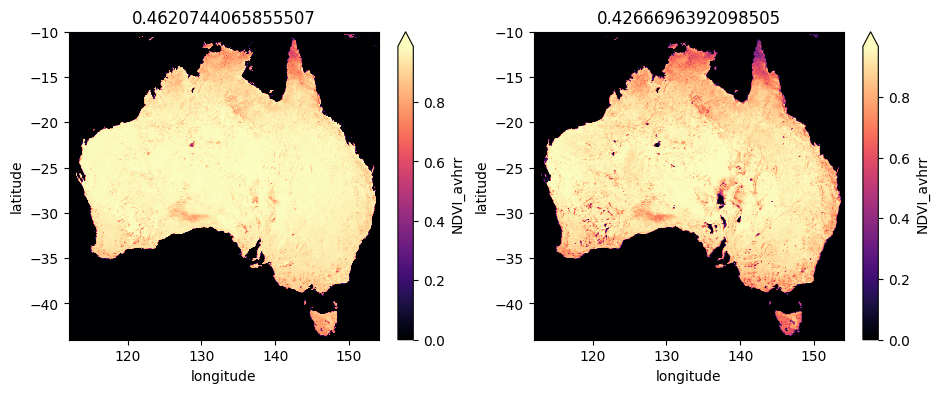

In [7]:
after_fraction_avail = (~np.isnan(ds['NDVI_avhrr'])).sum('time')/len(ds.time)

fig,ax=plt.subplots(1,2, figsize=(11,4))
before_fraction_avail.plot.imshow(robust=True, ax=ax[0], cmap='magma')
after_fraction_avail.plot.imshow(robust=True, ax=ax[1], cmap='magma')
ax[0].set_title(str(before_fraction_avail.mean().values));
ax[1].set_title(str(after_fraction_avail.mean().values));

### Add lagged NDVI features

In [8]:
ds['NDVI_avhrr_1f'] = ds['NDVI_avhrr'].shift(time=1)
ds['NDVI_avhrr_1b'] = ds['NDVI_avhrr'].shift(time=-1)
# ds['NDVI_avhrr_2f'] = ds['NDVI_avhrr'].shift(time=2)
# ds['NDVI_avhrr_2b'] = ds['NDVI_avhrr'].shift(time=-2)

In [11]:
# ds = ds.sel(time=slice(t1, t2))
ds = ds.drop('month')

### Open covariables

In [12]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

datasets = [
    'NDVI_harmonization/MODIS_NDVI_5km_monthly_200003_202212.nc',
    '5km/rain_cml3_5km_monthly_1982_2022.nc',
    '5km/srad_5km_monthly_1982_2022.nc',
           ]

In [14]:
dss = []
names = []
for d in datasets:
    xx =  assign_crs(xr.open_dataset(base+d),crs='epsg:4326').sel(time=slice('1982','2013'))
    if "MODIS" in d:
        xx = xx.odc.reproject(how=ds.odc.geobox)
        xx = round_coords(xx)
    xx = assign_crs(xx, crs ='epsg:4326')
    xx = round_coords(xx)
    xx = xx.drop('spatial_ref')
    names.append(list(xx.data_vars)[0])
    dss.append(xx.transpose('time', 'latitude', 'longitude'))

covars = xr.merge(dss)
covars = assign_crs(covars, crs ='epsg:4326')
covars = covars.rename({'NDVI_median':'NDVI_modis'})

#merge the AVHR with covariables
ds = xr.merge([ds,covars])

### Add some MODIS summary stats

In [15]:
mean_modis = ds['NDVI_modis'].mean('time')
mean_modis = mean_modis.expand_dims(time=ds.time)
ds['NDVI_modis_mean'] = mean_modis

min_modis = ds['NDVI_modis'].quantile(0.05, dim='time').drop('quantile')
min_modis = min_modis.expand_dims(time=ds.time)
ds['NDVI_modis_min'] = min_modis

max_modis = ds['NDVI_modis'].quantile(0.95, dim='time').drop('quantile')
max_modis = max_modis.expand_dims(time=ds.time)
ds['NDVI_modis_max'] = max_modis

#remove unneeded variables
ds = ds.drop(['NDVI_stddev', 'n_obs', 'ndvi_cv', 'NDVI_modis'])

In [21]:
for i in ds.data_vars:
    try:
        del ds[i].attrs['grid_mapping']
    except:
        continue

In [22]:
ds.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_5km_monthly_1982_2013_extraFeatures.nc')